In [22]:
from astropy.io import fits
import numpy as np

import matplotlib.pyplot as plt
import pandas as pd

import glob


def get_folder(date):
    files = glob.glob(f"/home/ilin/Documents/2024_03_HIP67522_CHEOPS/data/hip67522/"
                    f"CHEOPS-products-**/**{date}*.fits")
    folder = files[0].split("/")[-2]
    return folder




def get_lc(folder):
    hdulist = fits.open("/home/ilin/Documents/2024_03_HIP67522_CHEOPS/data/hip67522/"
                        f"{folder}/Outdata/00000/hip67522_{folder}_im.fits")


    # get the image data
    image_data = hdulist[1].data

    t, f, ferr, roll, flag = image_data["MJD_TIME"], image_data["FLUX"], image_data["FLUXERR"], image_data["ROLL"], image_data["FLAG"]

    # make sure the data is in fact 10s cadence
    assert np.diff(t).min() * 24 * 60 * 60 < 10.05, "Time series is not 10s cadence"

    # big endian to little endian
    time = t.byteswap().newbyteorder()
    flux = f.byteswap().newbyteorder()
    ferr = ferr.byteswap().newbyteorder()
    roll = roll.byteswap().newbyteorder()
    flag = flag.byteswap().newbyteorder()


    tp = time[flag == 0] + 2400000.5
    fp = flux[flag == 0]

    return tp, fp

def get_atca_lc(date, min30=False):
    
    tstamp = date.replace("-", "")
    tstartloc = f"/home/ilin/Documents/2024_04_HIP67522_ATCA/results/{tstamp}/timeseries/tstart.txt"
    lcloc = f"/home/ilin/Documents/2024_04_HIP67522_ATCA/results/{tstamp}/timeseries/timeseries.csv"

    tstart = str(np.loadtxt(tstartloc, dtype=str))
    at = pd.read_csv(lcloc)

    at["time"] = pd.to_datetime(f"{date} " + at['num'].astype(str).str.replace("_", ":") + ":" + tstart[-2:], utc=True)


    print(at["time"])

    # convert to jd with astropy
    at["time"] = at["time"].apply(lambda x: x.to_julian_date())


    if min30:
        tstartloc = f"/home/ilin/Documents/2024_04_HIP67522_ATCA/results/{tstamp}/timeseries30/tstart.txt"
        lcloc = f"/home/ilin/Documents/2024_04_HIP67522_ATCA/results/{tstamp}/timeseries30/timeseries.csv"

        tstart = str(np.loadtxt(tstartloc, dtype=str))
        at30 = pd.read_csv(lcloc)


        at30["time"] = pd.to_datetime(f"{date} " + at30['num'].astype(str).str.replace("_", ":") + ":" + tstart[-2:])

        # convert to jd with astropy
        at30["time"] = at30["time"].apply(lambda x: x.to_julian_date())
        return at30
    
    else:
        return at


In [23]:

date, midp, loctran, cheops, period, at30 = "2024-04-28", None, None, ["2024-04-28","2024-04-30","2024-05-03"], 1.4112, False
date, midp, loctran, cheops, period, at30 = "2024-05-31", 2460462.2, 0.00005, ["2024-05-24","2024-05-26","2024-05-31"], 1.4112, False
# date, midp, loctran = "2024-06-14", 2460476.13002, 0.00005
date, midp, loctran = "2024-05-11", None, None





folder = get_folder(date)

print(folder)

tp, fp = get_lc(folder)


at = get_atca_lc(date)

if at30:
    at30 = get_atca_lc(date, min30=True)


CHEOPS-products-20240513144617
0    2024-05-11 06:59:00+00:00
1    2024-05-11 07:59:00+00:00
2    2024-05-11 08:59:00+00:00
3    2024-05-11 09:59:00+00:00
4    2024-05-11 10:59:00+00:00
5    2024-05-11 11:59:00+00:00
6    2024-05-11 12:59:00+00:00
7    2024-05-11 13:59:00+00:00
8    2024-05-11 14:59:00+00:00
9    2024-05-11 15:59:00+00:00
10   2024-05-11 16:59:00+00:00
11   2024-05-11 17:59:00+00:00
Name: time, dtype: datetime64[ns, UTC]


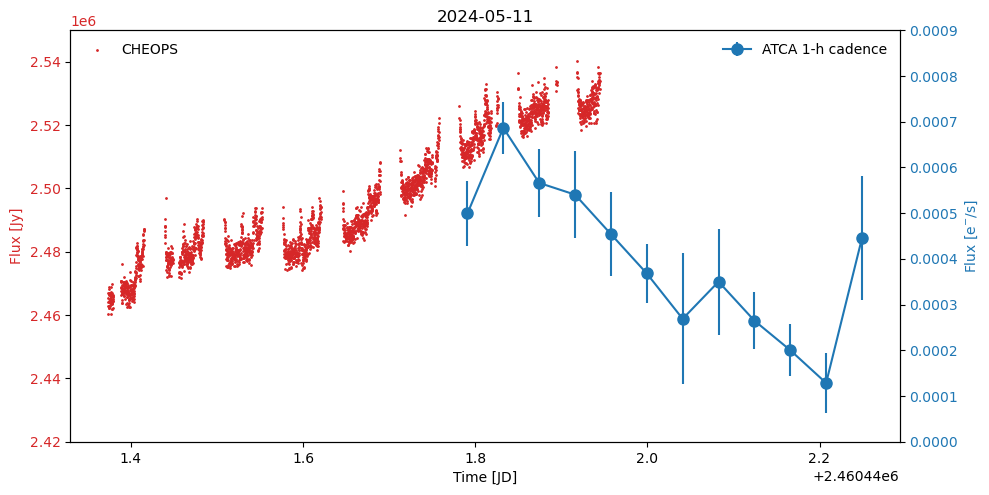

In [24]:

# plot the above again but now each time series with its own y-axis
fig, ax1 = plt.subplots(figsize=(10, 5))

color = 'tab:red'
ax1.set_xlabel('Time [JD]')
ax1.set_ylabel('Flux [Jy]', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.scatter(tp, fp, s=1, color=color, label="CHEOPS")   
# ax1.errorbar(at["time"], at.source_J, yerr=at.bkg_rms_J, markersize=10, fmt='o-', color=color, label="ATCA 1-h cadence" )

plt.legend(loc=2, frameon=False)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel(r'Flux [e$^{-}$/s]', color=color)  # we already handled the x-label with ax1
# ax2.scatter(tp, fp, s=1, color=color, label="CHEOPS")   
if at30:
    ax2.errorbar(at30["time"], at30.source_J, yerr=at30.bkg_rms_J, markersize=3, fmt='o', color=color, alpha=0.25,  label="ATCA 30-min cadence")
ax2.errorbar(at["time"], at.source_J, yerr=at.bkg_rms_J, markersize=8, fmt='o-', color=color, label="ATCA 1-h cadence" )


ax2.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(2.42e6,2.55e6)
ax2.set_ylim(0,0.0009)


plt.legend(loc=1, frameon=False)    

fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.title(date)


if midp is not None:
    ax1.axvspan(midp-0.1, midp+0.1, alpha=0.25, color='gray')
    ax1.text(midp, loctran,"HIP 67522 b transit", verticalalignment='bottom', horizontalalignment='center')

tstamp = date.replace("-", "")
# plt.savefig(f"../plots/{tstamp}_CHEOPS_ATCA.png", dpi=300)

# Compare phase folded 

In [72]:

atca, midp, loctran, cheops, period, at30 = ["2024-06-11","2024-06-14"], 2460462.2, 0.00005, ["2024-05-26","2024-05-31","2024-06-07","2024-06-14" ], 1.4112, False
# "2024-05-31", "2024-06-11", 
folders = [get_folder(date) for date in cheops]


In [73]:
lcs = [get_lc(folder) for folder in folders]

# phase fold each lc with period
phases = [np.mod(tp - 60370, period) / period for tp, _ in lcs]

In [74]:
ats = [get_atca_lc(date) for date in atca]

# phase fold atca data
for at in ats:
    at["phase"] = np.mod(at["time"] - 60370, period) / period



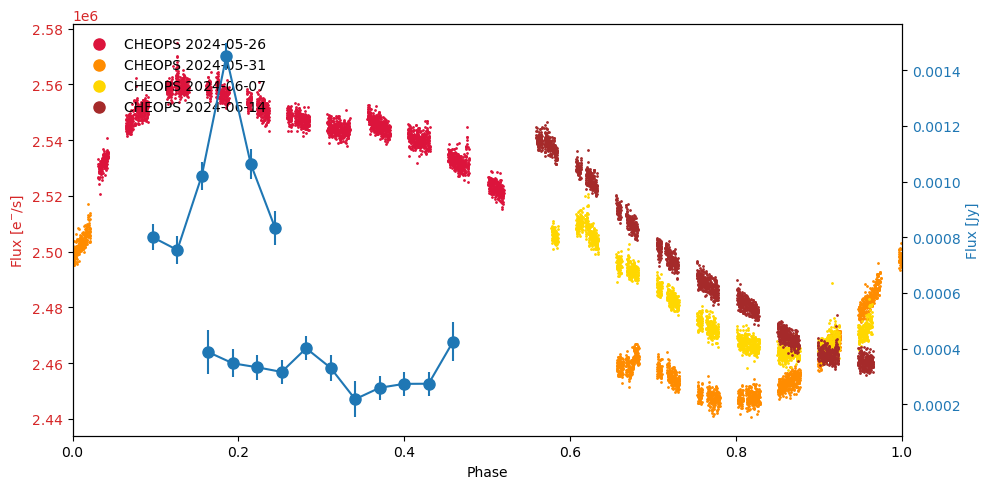

In [76]:
# plot the above again but now each time series with its own y-axis
fig, ax1 = plt.subplots(figsize=(10, 5))

color = 'tab:red'
ax1.set_xlabel('Phase')
ax1.set_ylabel(r'Flux [e$^{-}$/s]', color=color)
ax1.tick_params(axis='y', labelcolor=color)
colors = ["crimson", "darkorange", "gold", "brown", "red"]  

for i, (tp, fp) in enumerate(lcs):
    ax1.scatter(phases[i], fp, s=1, color=colors[i], label=f"CHEOPS {cheops[i]}")
# ax1.errorbar(at["phase"], at.source_J, yerr=at.bkg_rms_J, markersize=10, fmt='o-', color=color, label="ATCA 1-h cadence" )

plt.legend(loc=2, frameon=False, markerscale=8)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Flux [Jy]', color=color)  # we already handled the x-label with ax1
# ax2.scatter(tp, fp, s=1, color=color, label="CHEOPS")
if at30:
    ax2.errorbar(at30["phase"], at30.source_J, yerr=at30.bkg_rms_J, markersize=3, fmt='o', color=color, alpha=0.25,  label="ATCA 30-min cadence")
for i, at in enumerate(ats):
    ax2.errorbar(at["phase"], at.source_J, yerr=at.bkg_rms_J, markersize=8, fmt='o-', color=color, label="ATCA 1-h cadence" )


ax2.tick_params(axis='y', labelcolor=color)
# ax1.set_ylim(2.42e6,2.55e6)
# ax2.set_ylim(0,0.0009)
ax1.set_xlim(0, 1)
plt.tight_layout()
plt.savefig(f"../plots/{tstamp}_CHEOPS_ATCA_phased.png", dpi=300)

